# Object detection using Faster R-CNN

In [ ]:
! wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/DLguys.jpeg
! wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/watts_photos2758112663727581126637_b5d4d192d4_b.jpeg
! wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/istockphoto-187786732-612x612.jpeg
! wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/jeff_hinton.png

## Import

In [1]:
import torchvision
from torchvision import  transforms 
import torch
from torch import no_grad

import requests

import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

Functions

In [51]:
def get_predictions(pred,threshold=0.8,objects=None ):
    """
    This function will assign a string name to a predicted class and eliminate predictions whose likelihood  is under a threshold 
    
    pred: a list where each element contains a tuple that corresponds to information about  the different objects; Each element includes a tuple with the class yhat, probability of belonging to that class and the coordinates of the bounding box corresponding to the object 
    image : frozen surface
    predicted_classes: a list where each element contains a tuple that corresponds to information about  the different objects; Each element includes a tuple with the class name, probability of belonging to that class and the coordinates of the bounding box corresponding to the object 
    thre
    """


    predicted_classes= [(COCO_INSTANCE_CATEGORY_NAMES[i],p,[(box[0], box[1]), (box[2], box[3])]) for i,p,box in zip(list(pred[0]['labels'].numpy()),pred[0]['scores'].detach().numpy(),list(pred[0]['boxes'].detach().numpy()))]
    predicted_classes=[  stuff  for stuff in predicted_classes  if stuff[1]>threshold ]
    
    if objects  and predicted_classes :
        predicted_classes=[ (name, p, box) for name, p, box in predicted_classes if name in  objects ]
    return predicted_classes

def draw_box(predicted_classes,image,rect_th= 10,text_size= 3,text_th=3):
    """
    draws box around each object 
    
    predicted_classes: a list where each element contains a tuple that corresponds to information about  the different objects; Each element includes a tuple with the class name, probability of belonging to that class and the coordinates of the bounding box corresponding to the object 
    image : frozen surface 
   
    """

    img=(np.clip(cv2.cvtColor(np.clip(image.numpy().transpose((1, 2, 0)),0,1), cv2.COLOR_RGB2BGR),0,1)*255).astype(np.uint8).copy()
    for predicted_class in predicted_classes:
   
        label=predicted_class[0]
        probability=predicted_class[1]
        box=predicted_class[2]
        #print(type(box[0]))
        pt1 = (int(box[0][0]),int(box[0][1]))  #box[0]
        pt2 = (int(box[1][0]),int(box[1][1]))  #box[1]

        cv2.rectangle(img, pt1, pt2,(0, 255, 0), rect_th) # Draw Rectangle with the coordinates
        cv2.putText(img,label, pt1,  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) 
        cv2.putText(img,label+": "+str(round(probability,2)), pt1,  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    del(img)
    del(image)

def save_RAM(image_=False):
    global image, img, pred
    torch.cuda.empty_cache()
    del(img)
    del(pred)
    if image_:
        image.close()
        del(image)

## Load Pre-trained Faster R-CNN

<a href='https://arxiv.org/abs/1506.01497?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkCV0101ENCoursera25797139-2021-01-01'>Faster R-CNN</a> is a model that predicts both bounding boxes and class scores for potential objects in the image  pre-trained on <a href="https://cocodataset.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkCV0101ENCoursera25797139-2021-01-01">COCO<a>.

In [ ]:
model_ = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model_.eval()

for name, param in model_.named_parameters():
    param.requires_grad = False
print("done")

the function calls Faster R-CNN <code> model\_ </code> but save RAM:

In [7]:
def model(x):
    with torch.no_grad():
        yhat = model_(x)
    return yhat

Here are the 91 classes

In [8]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
len(COCO_INSTANCE_CATEGORY_NAMES)

91

## Object Localization

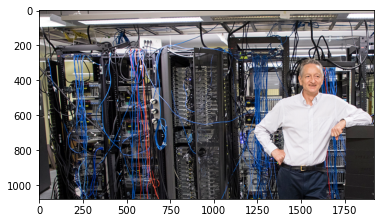

In [27]:
img_path='jeff_hinton.png'
half = 0.5
image = Image.open(img_path)

image.resize( [int(half * s) for s in image.size] )

plt.imshow(image)
plt.show()

In [28]:
# Convert image to a tensor
transform = transforms.Compose([transforms.ToTensor()])
img = transform(image)

# Make a prediction
pred = model([img])

# Observe pred
pred[0]['labels']

tensor([ 1, 15, 84,  2, 35, 84, 62,  2,  7, 84, 82, 84, 35, 84,  2, 35, 15, 42,
         2, 82, 62, 84, 62, 84,  7,  2, 84,  7,  2,  9, 84, 84,  2, 84,  2])

we have the 35  different class predictions, ordered by likelihood scores for potential objects. We have the likehood (probability) of each class.

In [29]:
pred[0]['scores']

tensor([0.9995, 0.3495, 0.2695, 0.2556, 0.2466, 0.1929, 0.1861, 0.1766, 0.1593,
        0.1528, 0.1484, 0.1392, 0.1295, 0.1290, 0.1249, 0.1208, 0.1094, 0.1026,
        0.1023, 0.1019, 0.0846, 0.0827, 0.0826, 0.0794, 0.0785, 0.0738, 0.0735,
        0.0713, 0.0669, 0.0622, 0.0595, 0.0578, 0.0575, 0.0553, 0.0520])

In [30]:
index=pred[0]['labels'][0].item()
COCO_INSTANCE_CATEGORY_NAMES[index]

'person'

Coordinates of the bounding box

In [31]:
bounding_box=pred[0]['boxes'][0].tolist()
bounding_box

[1223.168701171875, 301.2502746582031, 1909.1724853515625, 1076.6370849609375]

We convert the tensor to an open CV array and plot an image with the box:


In [32]:
t,l,r,b=[round(x) for x in bounding_box]

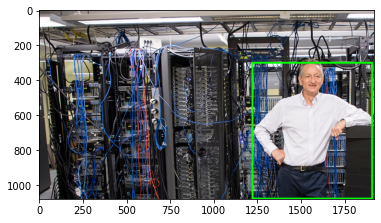

In [33]:
img_plot=(np.clip(cv2.cvtColor(np.clip(img.numpy().transpose((1, 2, 0)),0,1), cv2.COLOR_RGB2BGR),0,1)*255).astype(np.uint8)
cv2.rectangle(img_plot,(t,l),(r,b),(0, 255, 0), 10) # Draw Rectangle with the coordinates
plt.imshow(cv2.cvtColor(img_plot, cv2.COLOR_BGR2RGB))
plt.show()
del img_plot, t, l, r, b

We can localize objects; we do this using the function <code>get_predictions</code>. The input  is the predictions <code>pred</code> and the <code>objects</code> you would like to localize .


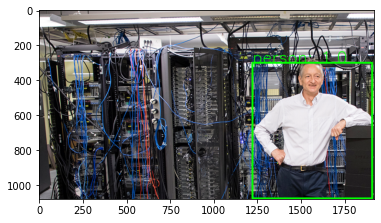

In [52]:
pred_class=get_predictions(pred,objects="person")
draw_box(pred_class, img)
del pred_class

We can set a threshold <code>threshold </code>. Here we set the  threshold 0.95 i.e Here we set the  threshold 1 i.e. 95% likelihood.


In [23]:
get_predictions(pred,threshold=0.95,objects="person")

[('person', 0.999546, [(1223.1687, 301.25027), (1909.1725, 1076.6371)])]

Delete objects to save memory, we will run this after every cell:

In [24]:
save_RAM(image_=True)

## Multiple objects localization

We can locate multiple objects, consider the following <a href='https://www.kdnuggets.com/2015/03/talking-machine-deep-learning-gurus-p1.html?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkCV0101ENCoursera25797139-2021-01-01'>image</a>, we can detect the people in the image.


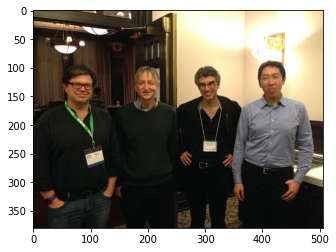

In [53]:
img_path='DLguys.jpeg'
image = Image.open(img_path)
image.resize([int(half * s) for s in image.size])
plt.imshow(np.array(image))
plt.show()

Threshold = 90 %

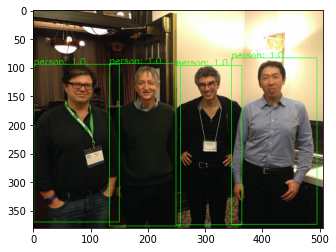

In [54]:
img = transform(image)
pred = model([img])
pred_thresh=get_predictions(pred,threshold=0.8,)
draw_box(pred_thresh,img,rect_th= 1,text_size= 0.5,text_th=1)
del pred_thresh

Or we can use objects parameter:

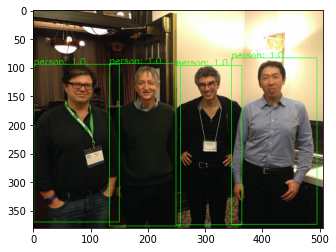

In [55]:

pred_obj=get_predictions(pred,objects="person")
draw_box(pred_obj,img,rect_th= 1,text_size= 0.5,text_th=1)
del pred_obj

In [56]:
save_RAM(image_=True)

## Object Detection

In Object Detection we find the classes as well detect the objects in an image. Consider the following <a href="https://www.dreamstime.com/stock-image-golden-retriever-puppy-lying-parakeet-perched-its-head-weeks-old-next-to-british-shorthair-kitten-sitting-image30336051?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkCV0101ENCoursera25797139-2021-01-01">image</a>


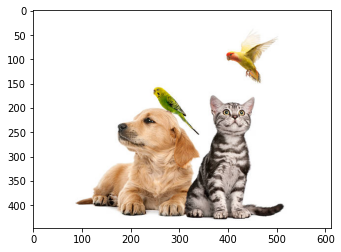

In [57]:
img_path='istockphoto-187786732-612x612.jpeg'
image = Image.open(img_path)
image.resize( [int(half * s) for s in image.size] )
plt.imshow(np.array(image))
plt.show()
del img_path

If we set a threshold, we can detect all objects whose likelihood is above that threshold.


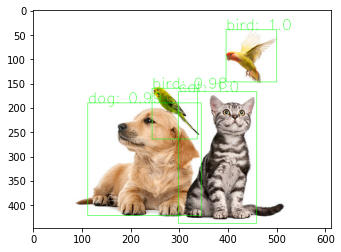

In [58]:
img = transform(image)
pred = model([img])
pred_thresh=get_predictions(pred,threshold=0.97)
draw_box(pred_thresh,img,rect_th= 1,text_size= 1,text_th=1)
del pred_thresh

In [ ]:
save_RAM(image_=True)